In [1]:
# import library
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.preprocessing import StandardScaler
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
from statsmodels.multivariate.manova import MANOVA
import math

import warnings 
warnings.filterwarnings("ignore")

#### Description 
Using the clustering method to segment customers based on the RFMTS model helps businesses better understand the behavior and distinctive characteristics of each customer segment. This can aid in customizing marketing strategies, customer care, and relationship management to optimize the value derived from each customer segment.

## <div align="center"><font color='CC3636'> <b>Table of contents</b></div>
    I. Merge sub-datasets into fact dataset
    II. Clean data
    III. EDA - Feature Selection 
    IV. Split sample dataset
        1. Clustering with K-mediods 
        2. Test K-means
        3. MANOVA test
        4. Cluster description

### I. Merge sub-datasets into fact dataset

In [2]:
# read datasets 
Payments = pd.read_csv('olist_order_payments_dataset.csv')
Orders = pd.read_csv('olist_orders_dataset.csv')
Customers = pd.read_csv('olist_customers_dataset.csv')
Reviews = pd.read_csv('olist_order_reviews_dataset.csv')

In [3]:
# merge data with inner join method 
data = Orders.merge(Customers, on="customer_id").merge(Payments, on="order_id").merge(Reviews, on="order_id")

In [4]:
# check null value on each column
data.isnull().sum()[data.isnull().sum() > 0]

order_approved_at                  171
order_delivered_carrier_date      1861
order_delivered_customer_date     3030
review_comment_title             91681
review_comment_message           60862
dtype: int64

In [5]:
# get only data delivered status  
data_delivered = data[data.order_status == 'delivered'].reset_index(drop=True)
#only delivered orders

In [6]:
# # check null value on each column
data_delivered.isnull().sum()[data_delivered.isnull().sum() > 0]

order_approved_at                   14
order_delivered_carrier_date         2
order_delivered_customer_date        8
review_comment_title             89025
review_comment_message           59830
dtype: int64

In [7]:
# Drop unneccesary columns
data_delivered = data_delivered.drop(['order_delivered_carrier_date', 'order_delivered_customer_date',
                                      'review_creation_date','review_answer_timestamp','order_estimated_delivery_date'], axis=1)

### II. Clean data

In [8]:
data_delivered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100649 entries, 0 to 100648
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   order_id                  100649 non-null  object 
 1   customer_id               100649 non-null  object 
 2   order_status              100649 non-null  object 
 3   order_purchase_timestamp  100649 non-null  object 
 4   order_approved_at         100635 non-null  object 
 5   customer_unique_id        100649 non-null  object 
 6   customer_zip_code_prefix  100649 non-null  int64  
 7   customer_city             100649 non-null  object 
 8   customer_state            100649 non-null  object 
 9   payment_sequential        100649 non-null  int64  
 10  payment_type              100649 non-null  object 
 11  payment_installments      100649 non-null  int64  
 12  payment_value             100649 non-null  float64
 13  review_id                 100649 non-null  o

In [9]:
data_delivered.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'review_id', 'review_score',
       'review_comment_title', 'review_comment_message'],
      dtype='object')

In [10]:
# convert object to datetime 
data_delivered['order_purchase_timestamp'] = pd.to_datetime(data_delivered['order_purchase_timestamp'])
data_delivered['order_approved_at'] = pd.to_datetime(data_delivered['order_approved_at'])

In [11]:
data_delivered.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,credit_card,1,18.12,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre..."
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,3,voucher,1,2.00,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre..."
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2,voucher,1,18.59,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre..."
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1,boleto,1,141.46,8d5266042046a06655c8db133d120ba5,4,Muito boa a loja,Muito bom o produto.
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1,credit_card,3,179.12,e73b67b67587f7644d5bd1a52deb1b01,5,NaN,NaN


In [22]:
# dữ liệu sau nối
# data_delivered.to_csv('Group_8_46K29.2.csv')

### III. EDA - Feature Selection

In [12]:
Latest_Date = data_delivered['order_purchase_timestamp'].max()
# get lastest date in datasets

In [13]:
RFMTS = data_delivered.groupby('customer_unique_id').agg({
                                                         'order_purchase_timestamp': lambda x: (Latest_Date - x.max()).days,  # cal R feature
                                                         'order_id': lambda x: x.nunique(), # cal F feature
                                                         'payment_value': lambda x: x.sum(), # cal M feature
                                                         'review_score': lambda x: x.mean() # cal S feature
                                                         })

# get only payment value > 0 
RFMTS = RFMTS.query('payment_value > 0')

# rename columns to
RFMTS.rename(columns={  'order_purchase_timestamp': 'Recency', 
                        'order_id': 'Frequency', 
                        'payment_value': 'Monetary',
                     'review_score': 'Satisfaction'}, inplace=True)

RFMTS 

,Recency,Frequency,Monetary,Satisfaction
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,5.0
0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,4.0
0000f46a3911fa3c0805444483337064,536,1,86.22,3.0
0000f6ccb0745a6a4b88665a16c9f078,320,1,43.62,4.0
0004aac84e0df4da2b147fca70cf8255,287,1,196.89,5.0
...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,446,1,2067.42,5.0
fffea47cd6d3cc0a88bd621562a9d061,261,1,84.58,4.0
ffff371b4d645b6ecea244b27531430a,567,1,112.46,5.0


In [14]:
# calculate interpurchase-Time
RFMTS["Shopping_Cycle"] = data_delivered.groupby('customer_unique_id').agg(
                                                {'order_purchase_timestamp': lambda x: ((x.max() - x.min()).days+1)})

# cal T feature
RFMTS["Interpurchase_Time"] = (RFMTS["Shopping_Cycle"] / RFMTS["Frequency"]).apply(lambda x: math.ceil(x))

In [15]:
RFMTS.Interpurchase_Time.value_counts(1) * 100

1      97.920305
4       0.057140
2       0.056062
5       0.049594
7       0.046359
         ...    
203     0.001078
199     0.001078
194     0.001078
291     0.001078
206     0.001078
Name: Interpurchase_Time, Length: 233, dtype: float64

In [16]:
RFMTS = RFMTS.drop(['Shopping_Cycle'], axis = 1)
RFMTS

,Recency,Frequency,Monetary,Satisfaction,Interpurchase_Time
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,5.0,1
0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,4.0,1
0000f46a3911fa3c0805444483337064,536,1,86.22,3.0,1
0000f6ccb0745a6a4b88665a16c9f078,320,1,43.62,4.0,1
0004aac84e0df4da2b147fca70cf8255,287,1,196.89,5.0,1
...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,446,1,2067.42,5.0,1
fffea47cd6d3cc0a88bd621562a9d061,261,1,84.58,4.0,1
ffff371b4d645b6ecea244b27531430a,567,1,112.46,5.0,1


In [17]:
RFMTS.describe()

,Recency,Frequency,Monetary,Satisfaction,Interpurchase_Time
count,92754.000000,92754.000000,92754.000000,92754.000000,92754.000000
mean,236.789907,1.033174,165.641621,4.153708,2.228863
std,152.593047,0.208416,226.497851,1.280061,11.765354
min,0.000000,1.000000,9.590000,1.000000,1.000000
25%,113.000000,1.000000,63.090000,4.000000,1.000000
50%,218.000000,1.000000,107.825000,5.000000,1.000000
75%,345.000000,1.000000,182.910000,5.000000,1.000000
max,694.000000,15.000000,13664.080000,5.000000,305.000000


In [18]:
RFMTS.reset_index().to_csv('RFMTS_data.csv', index=False)

### IV. Split sample dataset

In [20]:
# read data 
data = pd.read_csv('RFMTS_data.csv')
df = data

# filter with frequency -- 1 
data = data[data.Frequency == 1]

,customer_unique_id,Recency,Frequency,Monetary,Satisfaction,Interpurchase_Time
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,5.0,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,4.0,1
2,0000f46a3911fa3c0805444483337064,536,1,86.22,3.0,1
3,0000f6ccb0745a6a4b88665a16c9f078,320,1,43.62,4.0,1
4,0004aac84e0df4da2b147fca70cf8255,287,1,196.89,5.0,1
...,...,...,...,...,...,...
92749,fffcf5a5ff07b0908bd4e2dbc735a684,446,1,2067.42,5.0,1
92750,fffea47cd6d3cc0a88bd621562a9d061,261,1,84.58,4.0,1
92751,ffff371b4d645b6ecea244b27531430a,567,1,112.46,5.0,1
92752,ffff5962728ec6157033ef9805bacc48,118,1,133.69,5.0,1


In [21]:
## split data with 95% F = 1
cus_lst = data.customer_unique_id.to_list()
random_sample = random.sample(cus_lst, int(len(cus_lst) * 0.95))

filtered_df = df[~df['customer_unique_id'].isin(random_sample)]
filtered_df.head()

,customer_unique_id,Recency,Frequency,Monetary,Satisfaction,Interpurchase_Time
29,0011c98589159d6149979563c504cb21,389,1,117.94,5.0,1
32,0015752e079902b12cd00b9b7596276b,26,1,74.82,5.0,1
34,00191a9719ef48ebb5860b130347bf33,497,1,58.86,3.0,1
58,002ae492472e45ad6ebeb7a625409392,324,1,218.66,3.0,1
80,0036b4a3d09ad551a5188c2e374da402,384,1,162.77,4.0,1


In [22]:
filtered_df.to_csv('RFMTS_data1.csv', index=False)
# extract data info new file

### 23123

In [23]:
df = pd.read_csv('RFMTS_data1.csv')
df.head()

,customer_unique_id,Recency,Frequency,Monetary,Satisfaction,Interpurchase_Time
0,0011c98589159d6149979563c504cb21,389,1,117.94,5.0,1
1,0015752e079902b12cd00b9b7596276b,26,1,74.82,5.0,1
2,00191a9719ef48ebb5860b130347bf33,497,1,58.86,3.0,1
3,002ae492472e45ad6ebeb7a625409392,324,1,218.66,3.0,1
4,0036b4a3d09ad551a5188c2e374da402,384,1,162.77,4.0,1


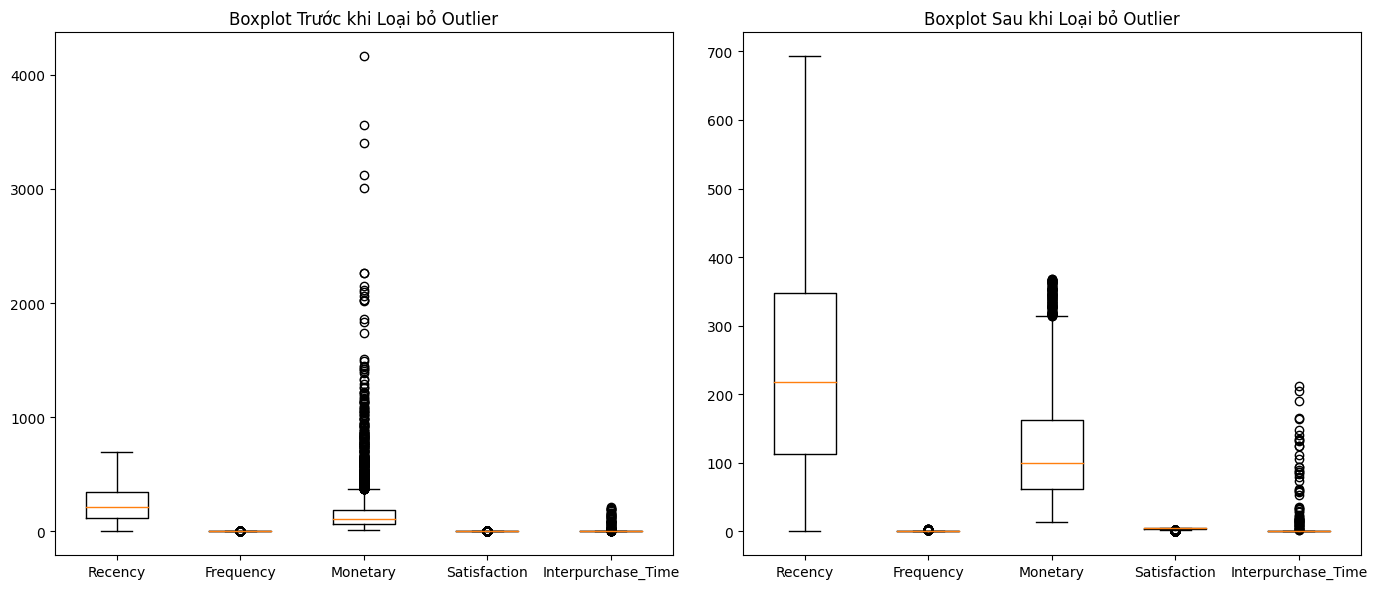

In [24]:
# boxplot graph before remove outliers 
data = df[['Recency','Frequency','Monetary','Satisfaction','Interpurchase_Time']]
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.boxplot(data.values, labels=data.columns)
plt.title("Boxplot Trước khi Loại bỏ Outlier")

# remove outlier R, M attribute with quantile range 
for column in ['Recency', 'Monetary']:
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# box plot graph after remove outlier
plt.subplot(1, 2, 2)
plt.boxplot(data.values, labels=data.columns)
plt.title("Boxplot Sau khi Loại bỏ Outlier")
plt.tight_layout()
plt.show()

In [25]:
X = data.values 
# assign data matrix to X variable

scaler = StandardScaler()
X = scaler.fit_transform(X)
# normalize data by z-score method

##### 1. Clustering with K-mediods

In [26]:
k_values = range(3, 11)

# list storage value of methods
inertia_values = []
calinski_scores = []
davies_scores = []
silhouette_scores = []

for k in k_values:
    kmedoids = KMedoids(n_clusters=k, random_state=42)
    kmedoids.fit(X)
    inertia_values.append(kmedoids.inertia_) 
    # calculate inertia values for elbow methods

    labels = kmedoids.labels_
    calinski_score = calinski_harabasz_score(X, labels)
    calinski_scores.append(calinski_score)
    davies_score = davies_bouldin_score(X, labels)
    davies_scores.append(davies_score)
    silhouette_score_value = silhouette_score(X, labels)
    silhouette_scores.append(silhouette_score_value)

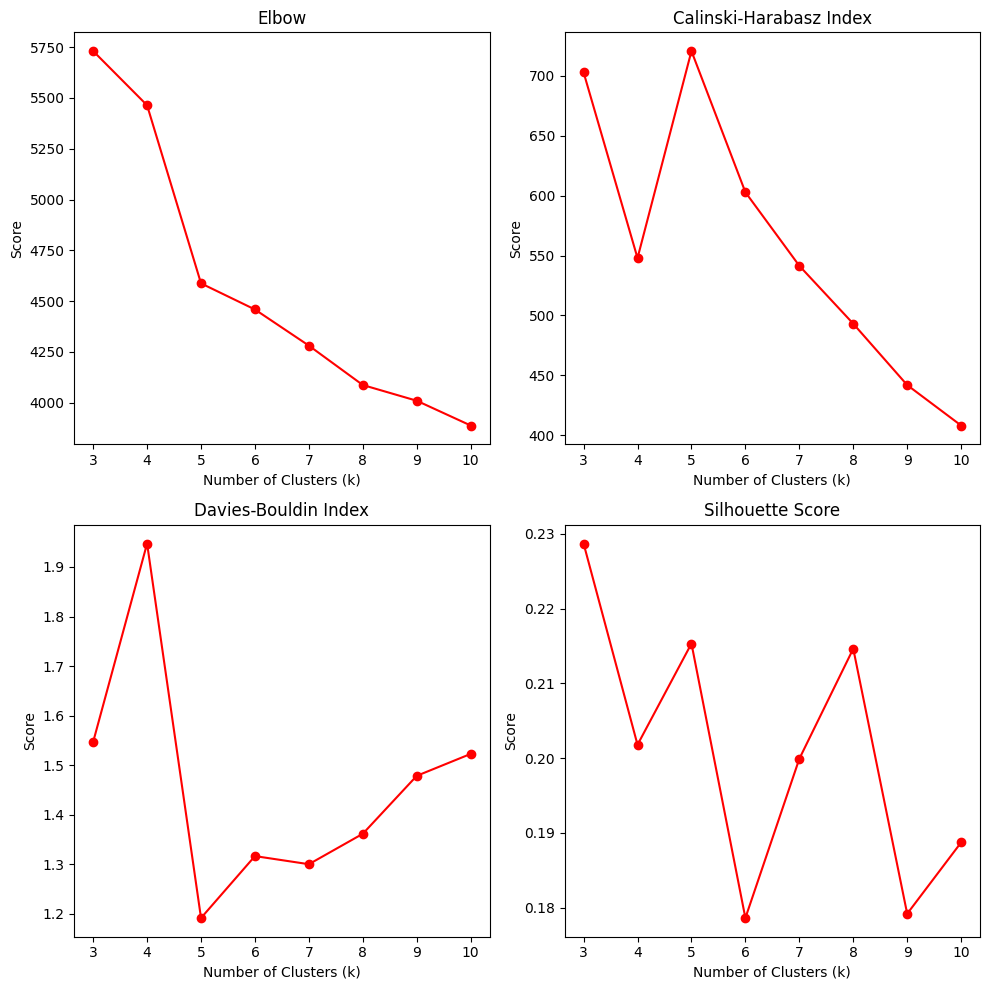

In [27]:
# create graph for visualize evaluation metrics 
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].plot(range(3, 11), inertia_values, marker='o', color='red')
axes[0, 0].set_title('Elbow')
axes[0, 0].set_xlabel('Number of Clusters (k)')
axes[0, 0].set_ylabel('Score')

axes[0, 1].plot(range(3, 11), calinski_scores, marker='o', color='red')
axes[0, 1].set_title('Calinski-Harabasz Index')
axes[0, 1].set_xlabel('Number of Clusters (k)')
axes[0, 1].set_ylabel('Score')

axes[1, 0].plot(range(3, 11), davies_scores, marker='o', color='red')
axes[1, 0].set_title('Davies-Bouldin Index')
axes[1, 0].set_xlabel('Number of Clusters (k)')
axes[1, 0].set_ylabel('Score')

axes[1, 1].plot(range(3, 11), silhouette_scores, marker='o', color='red')
axes[1, 1].set_title('Silhouette Score')
axes[1, 1].set_xlabel('Number of Clusters (k)')
axes[1, 1].set_ylabel('Score')

plt.tight_layout()
plt.show()

In [28]:
n_clusters = 5 
# choose the optimal number k 

# detail clustering with optimal k 
kmedoids = KMedoids(n_clusters=n_clusters, random_state=42)
kmedoids.fit(X)
labels = kmedoids.labels_

silhouette = silhouette_score(X, labels)
davies_bouldin = davies_bouldin_score(X, labels)
calinski_harabasz = calinski_harabasz_score(X, labels)

# create df for storage evaluation metrics
evaluation_df = pd.DataFrame(data=[[silhouette, davies_bouldin, calinski_harabasz]],
                              columns=['Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Index'])

# show results
evaluation_df

,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index
0,0.215332,1.191895,720.704168


In [29]:
RFMTS_Segmentation = data.assign(Cluster=labels) 
# assign cluster for each point
RFMTS_Segmentation

,Recency,Frequency,Monetary,Satisfaction,Interpurchase_Time,Cluster
0,389,1,117.94,5.0,1,3
1,26,1,74.82,5.0,1,4
2,497,1,58.86,3.0,1,3
3,324,1,218.66,3.0,1,1
4,384,1,162.77,4.0,1,3
...,...,...,...,...,...,...
4633,141,1,188.12,1.0,1,0
4634,222,1,51.75,5.0,1,2
4635,174,1,85.37,5.0,1,2
4636,217,1,226.90,4.0,1,1


In [30]:
RFMTS_Segmentation['Cluster'].value_counts()

4    952
2    874
3    851
1    841
0    772
Name: Cluster, dtype: int64

##### 2. Test K-means

In [31]:
X_kmeans = X

In [32]:
k_values = range(3, 11)

# list storage value of methods
inertia_values = []
calinski_scores = []
davies_scores = []
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_kmeans)
    inertia_values.append(kmeans.inertia_) 
    # calculate inertia values for elbow methods

    labels = kmeans.labels_
    calinski_score = calinski_harabasz_score(X_kmeans, labels)
    calinski_scores.append(calinski_score)
    davies_score = davies_bouldin_score(X_kmeans, labels)
    davies_scores.append(davies_score)
    silhouette_score_value = silhouette_score(X_kmeans, labels)
    silhouette_scores.append(silhouette_score_value)

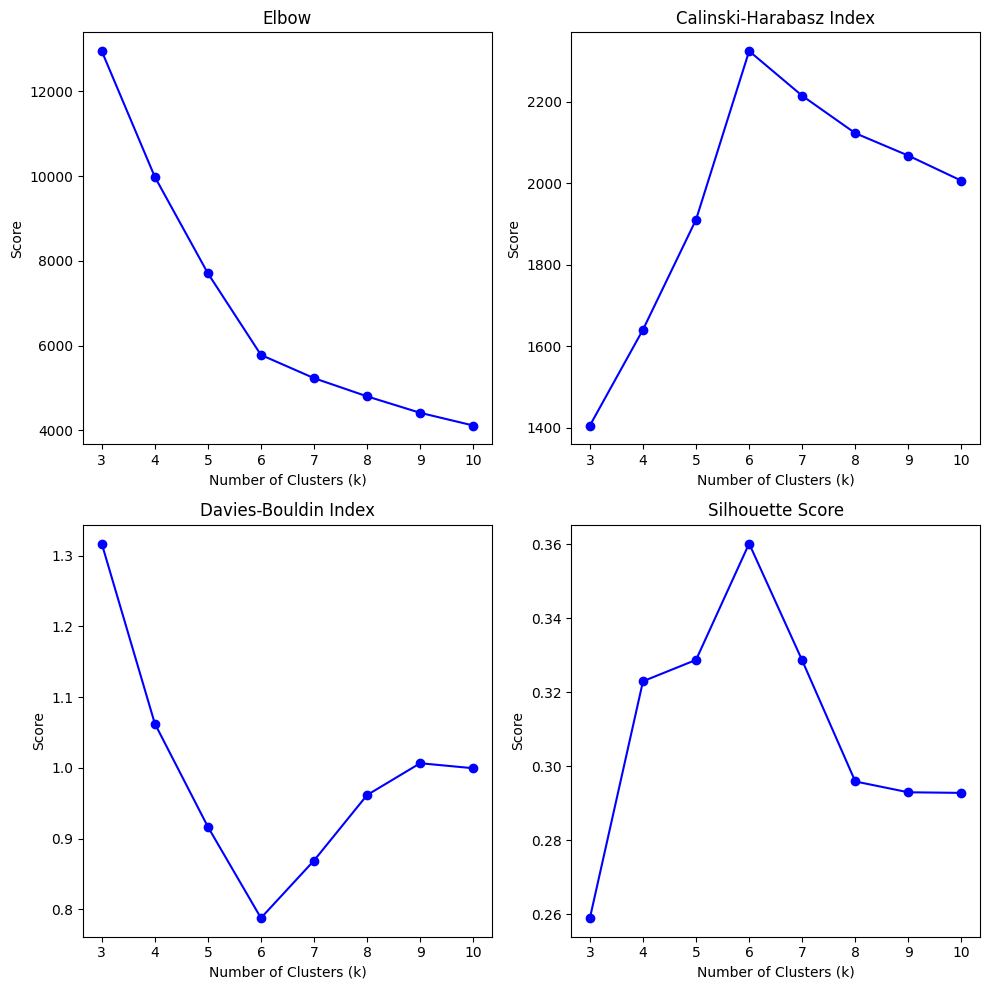

In [33]:
# create graph for visualize evaluation metrics 
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].plot(range(3, 11), inertia_values, marker='o', color='blue')
axes[0, 0].set_title('Elbow')
axes[0, 0].set_xlabel('Number of Clusters (k)')
axes[0, 0].set_ylabel('Score')

axes[0, 1].plot(range(3, 11), calinski_scores, marker='o', color='blue')
axes[0, 1].set_title('Calinski-Harabasz Index')
axes[0, 1].set_xlabel('Number of Clusters (k)')
axes[0, 1].set_ylabel('Score')

axes[1, 0].plot(range(3, 11), davies_scores, marker='o', color='blue')
axes[1, 0].set_title('Davies-Bouldin Index')
axes[1, 0].set_xlabel('Number of Clusters (k)')
axes[1, 0].set_ylabel('Score')

axes[1, 1].plot(range(3, 11), silhouette_scores, marker='o', color='blue')
axes[1, 1].set_title('Silhouette Score')
axes[1, 1].set_xlabel('Number of Clusters (k)')
axes[1, 1].set_ylabel('Score')

plt.tight_layout()
plt.show()

In [34]:
n_clusters = 5 # choose the optimal number k 

# detail clustering with optimal k 
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_kmeans)
labels = kmeans.labels_

silhouette = silhouette_score(X_kmeans, labels)
davies_bouldin = davies_bouldin_score(X_kmeans, labels)
calinski_harabasz = calinski_harabasz_score(X_kmeans, labels)

# create df for storage evaluation metrics
evaluation_df = pd.DataFrame(data=[[silhouette, davies_bouldin, calinski_harabasz]],
                              columns=['Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Index'])

# show results
evaluation_df

,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index
0,0.328756,0.916565,1910.610218


In [35]:
RFMTS_Segmentation = data.assign(Cluster=labels) 
# assign cluster for each point
RFMTS_Segmentation.head()

,Recency,Frequency,Monetary,Satisfaction,Interpurchase_Time,Cluster
0,389,1,117.94,5.0,1,2
1,26,1,74.82,5.0,1,4
2,497,1,58.86,3.0,1,2
3,324,1,218.66,3.0,1,0
4,384,1,162.77,4.0,1,2


In [36]:
RFMTS_Segmentation['Cluster'].value_counts()

4    2000
2    1476
0     723
3      69
1      22
Name: Cluster, dtype: int64

##### 3. Kiểm định MANOVA

In [37]:
# testing MANOVA
manova = MANOVA.from_formula('Recency + Frequency + Monetary + Interpurchase_Time + Satisfaction ~ Cluster', 
                             data=RFMTS_Segmentation)
print(manova.mv_test())

                    Multivariate linear model
                                                                  
------------------------------------------------------------------
       Intercept         Value  Num DF   Den DF   F Value   Pr > F
------------------------------------------------------------------
          Wilks' lambda  0.0569 5.0000 4284.0000 14208.2021 0.0000
         Pillai's trace  0.9431 5.0000 4284.0000 14208.2021 0.0000
 Hotelling-Lawley trace 16.5829 5.0000 4284.0000 14208.2021 0.0000
    Roy's greatest root 16.5829 5.0000 4284.0000 14208.2021 0.0000
------------------------------------------------------------------
                                                                  
------------------------------------------------------------------
          Cluster         Value  Num DF   Den DF   F Value  Pr > F
------------------------------------------------------------------
            Wilks' lambda 0.2882 5.0000 4284.0000 2115.7815 0.0000
           Pilla

##### 4. Mô tả cụm trong Kmeans

In [38]:
print('Số lượng từng cụm: ')
RFMTS_Segmentation.groupby("Cluster").size()

Số lượng từng cụm: 


Cluster
0     723
1      22
2    1476
3      69
4    2000
dtype: int64

In [39]:
# calculate the means of each attribute of each cluster
clusters = RFMTS_Segmentation.groupby(['Cluster']).agg({
        'Recency': lambda x: x.mean(),
        'Frequency': lambda x: x.mean(),
        'Monetary': lambda x: x.mean(),
        'Interpurchase_Time': lambda x: x.mean(),
        'Satisfaction': lambda x: x.mean(),})

# count frequencies of each cluster
clusters['Value_counts'] =  RFMTS_Segmentation.groupby(['Cluster'])['Cluster'].count()
clusters.columns = ['Recency_mean', 'Frequency_mean', 'Monetary_mean',
                    'InterpurchaseTime_mean','Satisfaction_mean','Value_counts']
clusters.head(10)

,Recency_mean,Frequency_mean,Monetary_mean,InterpurchaseTime_mean,Satisfaction_mean,Value_counts
Cluster,,,,,,
0,227.629322,1.000000,122.913956,1.000000,1.727524,723
1,148.681818,2.090909,196.849091,126.136364,4.352273,22
2,396.759485,1.000000,121.900786,1.000000,4.623984,1476
3,257.115942,2.072464,201.488406,12.913043,4.177536,69
4,124.068500,1.000000,114.037645,1.000000,4.734500,2000


In [40]:
# ranking on each feature on global 

clusters['RankR'] = clusters['Recency_mean'].rank(ascending=True)
clusters['RankF'] = clusters['Frequency_mean'].rank(ascending=True)
clusters['RankM'] = clusters['Monetary_mean'].rank(ascending=True)
clusters['RankT'] = clusters['InterpurchaseTime_mean'].rank(ascending=True)
clusters['RankS'] = clusters['Satisfaction_mean'].rank(ascending=True)

In [41]:
cluster_rank = clusters[['RankR','RankF','RankM','RankT','RankS']] 
# get sub target dataframe 

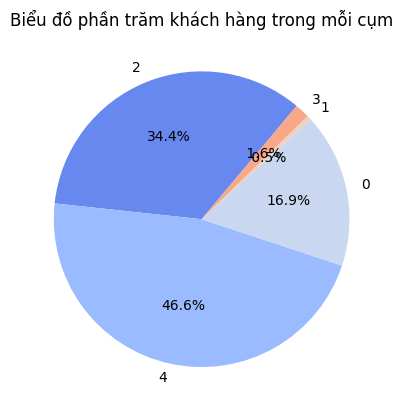

In [42]:
# visualize percent of the customer in each cluster

palette=sns.color_palette('coolwarm')
explodes = [0.25, 0.25, 0.25, 0.25, 0.25]
RFMTS_Segmentation["Cluster"].value_counts(sort=False).plot.pie(colors=palette,
                                                 textprops={'fontsize': 10},
                                                 autopct='%4.1f%%',
                                                 startangle= 50,
                                                 radius = 1,
                                                 shadow = False)
                                                # explode = explodes)
plt.ylabel("")
plt.title('Biểu đồ phần trăm khách hàng trong mỗi cụm')
plt.show()